In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
import krippendorff
from scipy.stats import bootstrap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
len(annotator_1), len(annotator_2)

(2000, 2000)

In [14]:
# Define emotion categories
positive_emotions = ['excitement', 'joy', 'satisfaction']
negative_emotions = ['sadness', 'frustration', 'anger']
caution_keywords = [
        'caution', 'warning', 'risk', 'careful', 'beware', 'cautious',
        'heed', 'watch out', 'danger', 'prudent', 'advisory', 'alert',
        'avoid', 'prevent', 'ensure', 'disable', 'check for', 'recoverable',
        'safe path', 'fallback', 'gracefully handle', 'validate', 'sanitize'
    ]
def emotion_corrections(df):
    # Map emotions in emotion_1 and emotion_2
    df['emotion'] = df['emotion'].apply(
        lambda x: 'satisfaction' if x in positive_emotions else 
                ('frustration' if x in negative_emotions else x)
    )

    # Define caution keywords and create mask
    
    pattern = '|'.join(caution_keywords)
    caution_mask = df['message'].str.contains(pattern, case=False, na=False)

    # Apply caution override where keywords are found
    df.loc[caution_mask, ['emotion']] = 'caution'

In [15]:
emotion_corrections(annotator_1)
emotion_corrections(annotator_2)

In [16]:
annotator_1['emotion'].unique(), annotator_2['emotion'].unique()

(array(['caution', 'satisfaction', 'neutral', 'frustration'], dtype=object),
 array(['caution', 'satisfaction', 'frustration', 'neutral'], dtype=object))

In [ ]:
annotator_1.to_csv('annotator_1_og.csv')
annotator_2.to_csv('annotator_2_og.csv')

In [19]:
annotator_2.columns

Index(['Unnamed: 0', 'commit', 'author', 'date', 'repo', 'project_size',
       'time_period', 'strat_label', 'message', 'emotion', 'intensity'],
      dtype='object')

In [20]:
annotator_1['emotion'].value_counts()

emotion
neutral         845
satisfaction    447
frustration     445
caution         263
Name: count, dtype: int64

In [21]:
nan_count = annotator_1['emotion'].isna().sum()
print(f"Number of NaN values in 'col_name': {nan_count}")


Number of NaN values in 'col_name': 0


In [22]:
annotator_2['emotion'].value_counts()

emotion
neutral         816
satisfaction    490
frustration     431
caution         263
Name: count, dtype: int64

In [23]:
nan_count = annotator_2['emotion'].isna().sum()
print(f"Number of NaN values in 'col_name': {nan_count}")


Number of NaN values in 'col_name': 0


In [ ]:
# Assuming your DataFrame is named 'df' and the column is named 'col'
def get_classes(column):
    # Count the occurrences of each category
    category_counts = column.value_counts()

    # Create a bar plot using seaborn
    sns.barplot(x=category_counts.index, y=category_counts)

    # Customize the plot (optional)
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.title('Distribution of Categories')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

    # Show the plot
    plt.show()

In [26]:
def get_metrics(df):
    # Step 3: Cohen's Kappa for emotions
    kappa_emotions = cohen_kappa_score(df['emotion_1'], df['emotion_2'])
    print(f"Cohen's Kappa for emotions: {kappa_emotions:.3f}")

    if kappa_emotions<=0.68:
        print("Cohen's Kappa too low! Threshold: 0.68")
    else:
        print("Cohen's Kappa looks good. Threshold: 0.68")


In [27]:

# Ensure necessary columns exist
required_columns = ['author', 'date', 'repo', 'message', 'emotion', 'intensity']
assert all(col in annotator_1.columns for col in required_columns), "Annotator 1 missing required columns"
assert all(col in annotator_2.columns for col in required_columns), "Annotator 2 missing required columns"


In [ ]:
# Define your key columns
key_cols = ['commit', 'author', 'date', 'repo', 'project_size', 
            'time_period', 'strat_label', 'message']

# STEP 1: Fix the data type for 'project_size' before any merging.
# This converts the column to a proper, nullable integer in both DataFrames.
annotator_1['project_size'] = pd.to_numeric(annotator_1['project_size'], errors='coerce').astype('Int64')
annotator_2['project_size'] = pd.to_numeric(annotator_2['project_size'], errors='coerce').astype('Int64')

# STEP 2: Normalize all string-based keys to remove hidden whitespace.
for col in key_cols:
    # Check if the column still exists and is of object type
    if col in annotator_1.columns and annotator_1[col].dtype == 'object':
        annotator_1[col] = annotator_1[col].str.strip()
    if col in annotator_2.columns and annotator_2[col].dtype == 'object':
        annotator_2[col] = annotator_2[col].str.strip()

# STEP 3: Perform the merge. It will now work.
print("Keys have been normalized. Attempting final merge...")
combined_df = pd.merge(
    annotator_1, annotator_2,
    on=key_cols,
    suffixes=('_1', '_2')
)

# STEP 4: Verify the result. The row count should now be correct.
print("--- Merge Complete ---")
print(f"Shape of the final combined_df: {combined_df.shape}")
print(combined_df.info())

Keys have been normalized. Attempting final merge...
--- Merge Complete ---
Shape of the final combined_df: (1994, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0_1  1994 non-null   int64  
 1   commit        1994 non-null   object 
 2   author        1994 non-null   object 
 3   date          1994 non-null   object 
 4   repo          1994 non-null   object 
 5   project_size  1994 non-null   Int64  
 6   time_period   1994 non-null   object 
 7   strat_label   1994 non-null   object 
 8   message       1994 non-null   object 
 9   emotion_1     1994 non-null   object 
 10  intensity_1   1991 non-null   float64
 11  Unnamed: 0_2  1994 non-null   int64  
 12  emotion_2     1994 non-null   object 
 13  intensity_2   1994 non-null   float64
dtypes: Int64(1), float64(2), int64(2), object(9)
memory usage: 220.2+ KB
None


In [29]:
len(combined_df)

1994

In [30]:
combined_df['emotion_1'].value_counts()

emotion_1
neutral         843
satisfaction    445
frustration     444
caution         262
Name: count, dtype: int64

In [31]:
combined_df['emotion_2'].value_counts()

emotion_2
neutral         814
satisfaction    488
frustration     430
caution         262
Name: count, dtype: int64

In [32]:
combined_df['intensity_1'].value_counts()

intensity_1
3.0    454
2.0    340
4.0    335
1.0    310
5.0    231
7.0    203
6.0    118
Name: count, dtype: int64

In [33]:

combined_df['intensity_2'].value_counts()

intensity_2
3.0    519
4.0    474
5.0    400
2.0    306
6.0    150
1.0     77
7.0     68
Name: count, dtype: int64

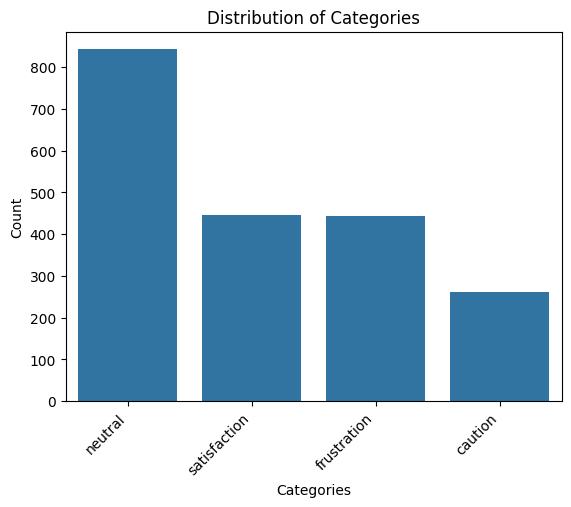

In [34]:
get_classes(combined_df['emotion_1'])

In [35]:
get_metrics(combined_df)

Cohen's Kappa for emotions: 0.412
Cohen's Kappa too low! Threshold: 0.68


In [ ]:
final_df = combined_df.copy()

In [38]:
def reconcile_emotions(row):
    e1, e2 = row['emotion_1'], row['emotion_2']
    i1, i2 = row['intensity_1'], row['intensity_2']
    
    # 1. Handle caution (highest priority)
    if e1 == 'caution' or e2 == 'caution':
        if e1 == 'caution' and e2 == 'caution':
            return 'caution', np.mean([i1, i2])
        return 'caution', i1 if e1 == 'caution' else i2
    
    # 2. Same emotion
    if e1 == e2:
        return e1, np.mean([i1, i2])
    
    # 3. One neutral, one non-neutral
    if 'neutral' in (e1, e2):
        non_neutral = e2 if e1 == 'neutral' else e1
        non_neutral_intensity = i2 if e1 == 'neutral' else i1
        return non_neutral, non_neutral_intensity
    
    # 4. Conflicting non-neutral emotions (satisfaction vs. frustration)
    if i1 > i2:
        return e1, i1
    elif i2 > i1:
        return e2, i2
    else:  # Tiebreaker
        return 'NEED REVIEW', i1

# Apply reconciliation
final_df[['reconciled_emotion', 'reconciled_intensity']] = final_df.apply(
    reconcile_emotions, 
    axis=1, 
    result_type='expand'
)

In [39]:
final_df.columns

Index(['Unnamed: 0_1', 'commit', 'author', 'date', 'repo', 'project_size',
       'time_period', 'strat_label', 'message', 'emotion_1', 'intensity_1',
       'Unnamed: 0_2', 'emotion_2', 'intensity_2', 'reconciled_emotion',
       'reconciled_intensity'],
      dtype='object')

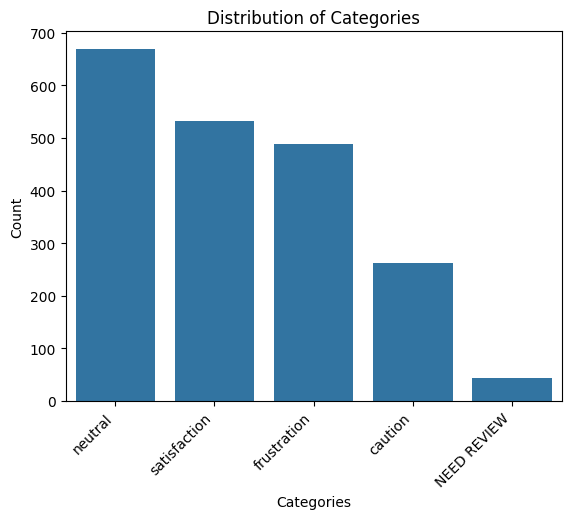

In [40]:
get_classes(final_df['reconciled_emotion'])

In [41]:
emotion_disagreements = final_df[final_df['emotion_1'] != final_df['emotion_2']]
emotion_disagreement_counts = emotion_disagreements['emotion_1'].value_counts()

print("Emotion disagreements:")
print(emotion_disagreement_counts)

Emotion disagreements:
emotion_1
neutral         174
satisfaction    128
frustration     117
Name: count, dtype: int64


In [42]:

# Step 7: Intensity disagreement analysis
# Analyze intensity level differences
intensity_differences = np.abs(final_df['intensity_1'] - final_df['intensity_2'])
intensity_disagreement_counts = intensity_differences.value_counts()

print("Intensity level disagreements:")
print(intensity_disagreement_counts)


Intensity level disagreements:
0.0    942
1.0    628
2.0    275
3.0     88
4.0     40
5.0     11
6.0      7
Name: count, dtype: int64


In [43]:
df_reconciled = final_df[['commit', 'author', 'date', 'repo', 'project_size',
       'time_period', 'strat_label', 'message', 'reconciled_emotion', 'reconciled_intensity']]

In [44]:
df_reconciled.head(5)

,commit,author,date,repo,project_size,time_period,strat_label,message,reconciled_emotion,reconciled_intensity
0,b90f6afa8bf33f8fbc8bec143eb6c6bba55eede8,chromium-autoroll <chromium-autoroll@skia-publ...,Thu May 7 13:15:17 2020 +0000,chromium/chromium,4568,2020Q2,4568 chromium/chromium 2020Q2,roll swiftshader afddeccdfeaa commits git log ...,caution,5.5
1,06f2fa0ec01cf00dbeace71fae41f61cafd0493f,Xing Liu <xingliu@chromium.org>,Thu Apr 30 02:45:19 2020 +0000,chromium/chromium,4568,2020Q2,4568 chromium/chromium 2020Q2,query tiles add a debug switch to immediately ...,satisfaction,3.5
2,232076f55e01fa311dea82cc802fd30e290a85ff,Yuzu Saijo <yuzus@chromium.org>,Fri May 29 07:14:02 2020 +0000,chromium/chromium,4568,2020Q2,4568 chromium/chromium 2020Q2,remove backforwardcache specific ipc and use m...,frustration,2.0
3,6a19a15fb7b5d7e92fd49b20b74f3f73ea7de6c9,Aaron Krajeski <aaronhk@chromium.org>,Tue Jun 16 21:17:35 2020 +0000,chromium/chromium,4568,2020Q2,4568 chromium/chromium 2020Q2,add ios to texturelayerskipwaitforactivation c...,neutral,6.0
4,ce6d2b585d2a62c0e36f4d49723b7aec838d9488,Minoru Chikamune <chikamune@chromium.org>,Fri Apr 24 00:14:49 2020 +0000,chromium/chromium,4568,2020Q2,4568 chromium/chromium 2020Q2,migrate beforeinstallpromptevent to use gc moj...,caution,5.0


In [45]:
df_reconciled['reconciled_intensity'].value_counts()

reconciled_intensity
3.0    367
4.0    300
2.0    262
5.0    213
3.5    143
2.5    134
1.0    125
6.0    108
1.5     97
4.5     93
5.5     76
7.0     49
6.5     24
Name: count, dtype: int64

In [46]:
len(df_reconciled)

1994

In [47]:
df_reconciled.to_csv('labeled_2k.csv')

In [48]:
df_unlabeled=df_reconciled.drop(columns=['reconciled_emotion',
       'reconciled_intensity'])

In [49]:
df_unlabeled.to_csv('unlabeled_2k.csv', index=False)

In [50]:
labeled_df = pd.read_csv('labeled_2k.csv')